https://www.shirin-glander.de/2019/01/text_classification_keras_data_prep/      
https://apilist.fun/?page=2
https://medium.com/rakuten-rapidapi/top-10-social-media-apis-twitter-facebook-instagram-and-many-more-5c13262c61fe
https://www.kaggle.com/anik424/sentiment-analysis-multiclassification-using-bert?select=train.txt

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

C:\Users\Abin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
import pandas as pd
import numpy as np
os.getcwd()
os.chdir('C:\\Users\\Abin\\Desktop\\Emotion_Prediction')

In [3]:
df_train = pd.read_csv('train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')

In [6]:
df_train.tail()

,Input,Sentiment
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger
15999,i know a lot but i feel so stupid because i ca...,sadness


In [191]:
df_train.head()

,Input,Sentiment,format
0,i didnt feel humiliated,sadness,train
1,i can go from feeling so hopeless to so damned...,sadness,train
2,im grabbing a minute to post i feel greedy wrong,anger,train
3,i am ever feeling nostalgic about the fireplac...,love,train
4,i am feeling grouchy,anger,train


X_train = df_train.Input.tolist()
X_test = df_test.Input.tolist()
y_train = df_train.Sentiment.tolist()
y_test = df_test.Sentiment.tolist()

print(len(X_train),len(X_test),len(y_train),len(y_test))

factors = ['anger', 'fear', 'joy', 'love', 'sadness','surprise']

encoding = { 'anger': 0,
    'fear': 1,
    'joy': 2,
    'love': 3,
    'sadness': 4,
    'surprise': 5
}

train_y = [encoding[key] for key in y_train]
test_y = [encoding[key] for key in y_test]

                                                         Contents

01. Data Sourcing, Data Cleaning and Sampling
02. Bag of Words Model
03. Cost Sensitive Learning and Evaluation Metrics
04. Building Base-Line Model (Logistic Regression)
05. Building Traditional Models (Random Forest, Support Vector Machine, Adaptive Boosting and Gradient Boosting)
06. Implementing Deep Neural Network
07. Word Embedings and Embedding layer
08. Implementing Convolutional Neural Network
09. Conclusion

                                           01. Data Sourcing, Data Cleaning and Sampling

In [7]:
df_train.Sentiment.value_counts() # Imbalanced Class

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Sentiment, dtype: int64

In [8]:
df_train['format']='train'
df_test['format']='test'

total_df=pd.concat([df_train,df_test],axis=0)
total_df.shape

(18000, 3)

                                                 01. Data Cleaning
                                                  
                                                  a. Tokenization (Word and Regex)
                                                  b. Convert Tokens to Lower Case
                                                  b. Filter Out Punctuation
                                                  c. Filter out Stop Words (and Pipeline)
                                                  d. Stem Words

                                            a. Tokenization (word_tokenize) 

In [9]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
df=total_df.copy()
df['tokenized_Tweet'] = df.Input.values
# Split each sentence into tokens
df['tokenized_Tweet']=df['tokenized_Tweet'].apply(lambda row: nltk.word_tokenize(row))
df['tokenized_Tweet'].head()

0                         [i, didnt, feel, humiliated]
1    [i, can, go, from, feeling, so, hopeless, to, ...
2    [im, grabbing, a, minute, to, post, i, feel, g...
3    [i, am, ever, feeling, nostalgic, about, the, ...
4                            [i, am, feeling, grouchy]
Name: tokenized_Tweet, dtype: object

In [11]:
df['tokenized_Tweet']=df['tokenized_Tweet'].astype('str')

                                           a. Tokenization (RegexpTokenizer) 

tokenizer that picks out sequences of alphanumeric characters as tokens and drops everything else: 
(example: azithromycin-induced, we can drop hypen here. )

In [12]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
df['tokenized_Tweet'] = df['tokenized_Tweet'].apply(lambda row: tokenizer.tokenize(row))
df['tokenized_Tweet'].head()

0                         [i, didnt, feel, humiliated]
1    [i, can, go, from, feeling, so, hopeless, to, ...
2    [im, grabbing, a, minute, to, post, i, feel, g...
3    [i, am, ever, feeling, nostalgic, about, the, ...
4                            [i, am, feeling, grouchy]
Name: tokenized_Tweet, dtype: object

                                               b. Convert Tokens to Lower Case

In [13]:
df['tokenized_Tweet'] = df['tokenized_Tweet'].apply(lambda row:[x.lower() for x in row])
df['tokenized_Tweet'].head()

0                         [i, didnt, feel, humiliated]
1    [i, can, go, from, feeling, so, hopeless, to, ...
2    [im, grabbing, a, minute, to, post, i, feel, g...
3    [i, am, ever, feeling, nostalgic, about, the, ...
4                            [i, am, feeling, grouchy]
Name: tokenized_Tweet, dtype: object

                                                 C. Filter Out Punctuation

In [14]:
df['token_filter']=df['tokenized_Tweet']
# remove all tokens that are not alphabetic
df['token_filter'] = df['token_filter'].apply(lambda row: [x for x in row if x.isalpha()])
df['token_filter'].head()

0                         [i, didnt, feel, humiliated]
1    [i, can, go, from, feeling, so, hopeless, to, ...
2    [im, grabbing, a, minute, to, post, i, feel, g...
3    [i, am, ever, feeling, nostalgic, about, the, ...
4                            [i, am, feeling, grouchy]
Name: token_filter, dtype: object

                                             d. Filter out Stop Words (and Pipeline)

In [15]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stop_words = set(stopwords.words('english'))
df['token_filter_Stop'] = df['token_filter'].apply(lambda row: [x for x in row if not x in stop_words])
df['token_filter_Stop'].head() # We, the, about etc words are removed from the sentences

0                            [didnt, feel, humiliated]
1    [go, feeling, hopeless, damned, hopeful, aroun...
2    [im, grabbing, minute, post, feel, greedy, wrong]
3    [ever, feeling, nostalgic, fireplace, know, st...
4                                   [feeling, grouchy]
Name: token_filter_Stop, dtype: object

                                                 e. Stem Words

In [17]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

In [18]:
df['token_filter_Stop_Stem'] = df['token_filter_Stop'].apply(lambda row: [porter.stem(word) for word in row])
df['token_filter_Stop_Stem'].head()

0                                [didnt, feel, humili]
1    [go, feel, hopeless, damn, hope, around, someo...
2         [im, grab, minut, post, feel, greedi, wrong]
3    [ever, feel, nostalg, fireplac, know, still, p...
4                                      [feel, grouchi]
Name: token_filter_Stop_Stem, dtype: object

                                              Sample to train and test set

In [20]:
data=df.copy() # Copying the original data frame

train_x=data.loc[data['format']=='train','token_filter_Stop_Stem']
train_x=train_x.astype('str')
y_train=data.loc[data['format']=='train','Sentiment']

test_x=data.loc[data['format']=='test','token_filter_Stop_Stem']
test_x=test_x.astype('str')
y_test=data.loc[data['format']=='test','Sentiment']


In [21]:
encoding = { 'anger': 0,
    'fear': 1,
    'joy': 2,
    'love': 3,
    'sadness': 4,
    'surprise': 5
}

train_y = [encoding[key] for key in y_train]
test_y = [encoding[key] for key in y_test]

                                                  02. Bag of Words Model
                              represent a whole sequence of words as a single feature vector. 

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()   # Instantiating and creating Count Vector object
vectorizer.fit(train_x)
X_train = vectorizer.transform(train_x)
X_test  = vectorizer.transform(test_x)
X_train

<16000x10357 sparse matrix of type '<class 'numpy.int64'>'
	with 143599 stored elements in Compressed Sparse Row format>

In [165]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [23]:
from sklearn.externals import joblib
# Save the model for future purpose
joblib.dump(vectorizer,'vectorizer.pkl')

['vectorizer.pkl']

In [24]:
############### future value #############

In [135]:
trial='I am very excited today'

In [136]:
from nltk.tokenize import word_tokenize
trial=nltk.word_tokenize(trial)
trial

['I', 'am', 'very', 'excited', 'today']

In [137]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
listToStr = ' '.join([str(elem) for elem in trial]) 
trial_02=tokenizer.tokenize(listToStr)
trial_02

['I', 'am', 'very', 'excited', 'today']

In [138]:
trial_03=[x.lower() for x in trial_02]
trial_03

['i', 'am', 'very', 'excited', 'today']

In [139]:
trial_04=[x for x in trial_03 if x.isalpha()]
trial_04

['i', 'am', 'very', 'excited', 'today']

In [140]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
trial_05=[x for x in trial_04 if not x in stop_words]
trial_05

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['excited', 'today']

In [141]:
porter = PorterStemmer()
trial_06=[porter.stem(x) for x in trial_05]
trial_06

['excit', 'today']

In [166]:
user_input={'twitter_post':[trial_06]}
df=pd.DataFrame(data=user_input,index=[0])
df

,twitter_post
0,"[excit, today]"


import scipy
matrix_output=scipy.sparse.csr_matrix(trial_06)
matrix_output

In [201]:
trial=['im grabbing a minute to post i feel greedy wrong']
#trial=['i feel strong and good overall']
trial

['im grabbing a minute to post i feel greedy wrong']

In [202]:
# load the model from disk
#vectorizer = joblib.load('vectorizer.pkl')
future_val=vectorizer.transform(trial).toarray()
future_val.shape

(1, 10357)

In [203]:
m=future_val[0]
count=0
for i in m:
    if i==1:
        count=count+1
count

4

In [204]:
pred=classifier.predict(future_val)
pred

array([0])

In [89]:
print(vectorizer.vocabulary_)

{'didnt': 2386, 'feel': 3233, 'humili': 4312, 'go': 3764, 'hopeless': 4254, 'damn': 2123, 'hope': 4253, 'around': 464, 'someon': 8379, 'care': 1313, 'awak': 607, 'im': 4398, 'grab': 3807, 'minut': 5759, 'post': 6934, 'greedi': 3852, 'wrong': 10232, 'ever': 3026, 'nostalg': 6211, 'fireplac': 3317, 'know': 5017, 'still': 8627, 'properti': 7094, 'grouchi': 3880, 'ive': 4725, 'littl': 5289, 'burden': 1191, 'late': 5097, 'wasnt': 9966, 'sure': 8825, 'take': 8928, 'milligram': 5731, 'time': 9180, 'recommend': 7346, 'amount': 301, 'fallen': 3162, 'asleep': 505, 'lot': 5359, 'faster': 3192, 'also': 263, 'like': 5246, 'funni': 3592, 'confus': 1804, 'life': 5230, 'teenag': 9000, 'jade': 4737, 'year': 10280, 'old': 6325, 'man': 5491, 'petrona': 6729, 'perform': 6682, 'well': 10021, 'made': 5445, 'huge': 4300, 'profit': 7072, 'romant': 7632, 'make': 5474, 'suffer': 8766, 'see': 7914, 'mean': 5609, 'someth': 8381, 'run': 7692, 'divin': 2532, 'experi': 3095, 'expect': 3091, 'type': 9464, 'spiritu': 

Vocabulary is created from all the unique words which is tokenized from each sentences
Each sentence is now with 11244 dimesnion (Feature Vector)

                                        04. Building Base-Line Model (Logistic Regression)

In [34]:
# Some required modules and libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, make_scorer, recall_score, f1_score, accuracy_score, precision_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

In [35]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(class_weight='balanced')
classifier.fit(X_train,train_y)
score = classifier.score(X_test,test_y)
score

0.855

In [36]:
pred=classifier.predict(X_train)
pred

array([4, 4, 0, ..., 2, 0, 4])

In [37]:
predicted_actuals=pd.DataFrame({'actual':list(train_y),'pred':pred})
predicted_actuals.head()

,actual,pred
0,4,4
1,4,4
2,0,0
3,3,3
4,0,0


In [38]:
import numpy as np
predicted_actuals['correct_prediction']=np.where(predicted_actuals['pred']==predicted_actuals['actual'],1,0)
predicted_actuals.head()

,actual,pred,correct_prediction
0,4,4,1
1,4,4,1
2,0,0,1
3,3,3,1
4,0,0,1


In [39]:
pd.crosstab(predicted_actuals['actual'],predicted_actuals['correct_prediction'],margins=True)

correct_prediction,0,1,All
actual,,,
0,67,2092,2159
1,94,1843,1937
2,334,5028,5362
3,53,1251,1304
4,176,4490,4666
5,7,565,572
All,731,15269,16000


In [40]:
accuracy=accuracy_score(train_y,pred)
accuracy

0.9543125

In [41]:
import numpy as np
pred=classifier.predict(X_test)
predicted_actuals=pd.DataFrame({'actual':list(test_y),'pred':pred})
predicted_actuals['correct_prediction']=np.where(predicted_actuals['pred']==predicted_actuals['actual'],1,0)
pd.crosstab(predicted_actuals['actual'],predicted_actuals['correct_prediction'],margins=True)

correct_prediction,0,1,All
actual,,,
0,41,234,275
1,40,184,224
2,91,604,695
3,38,121,159
4,71,510,581
5,9,57,66
All,290,1710,2000


In [42]:
from sklearn.externals import joblib
# Save the model for future purpose
joblib.dump(classifier,'Log_model.pkl')

['Log_model.pkl']

In [43]:
# load the model from disk
loaded_model = joblib.load('Log_model.pkl')
result = loaded_model.score(X_test,test_y)
print(result)

0.855


                                            05. Building Traditional Models 

                                                  a. Random Forest Model

In [29]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [75]:
# Choosing the optimal parameter for the classifier                     
param_grid = [{'max_depth':[30,32,34,36],'n_estimators':[100]}]
scorer={'accuracy_score': make_scorer(accuracy_score)}

#RF = RandomForestClassifier(random_state = 123,criterion='entropy',class_weight='balanced',max_features='sqrt')
RF = RandomForestClassifier(random_state = 123,criterion='entropy',class_weight='balanced')

RF_GS=GridSearchCV(RF,param_grid=param_grid,scoring=scorer,refit='accuracy_score',cv=10,n_jobs=-1)
RF_GS.fit(X_train,train_y)  
RF_GS.best_params_

{'max_depth': 34, 'n_estimators': 100}

In [76]:
RF_GS.best_score_

0.804125

In [30]:
# Build the model with the optimal parameter
RF_1 = RandomForestClassifier(random_state = 123,n_estimators=100,criterion='entropy',class_weight='balanced',max_depth=34)
#RF_1 = RandomForestClassifier(random_state = 123,n_estimators=3000,criterion='entropy',class_weight='balanced',max_depth=64,max_features='sqrt')
RF_1.fit(X_train,train_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=34, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

In [31]:
# predict on test set
pred_test_RF=RF_1.predict(X_train)
metrics.accuracy_score(train_y,pred_test_RF)

0.9113125

In [32]:
# predict on test set
pred_test_RF=RF_1.predict(X_test)
metrics.accuracy_score(test_y,pred_test_RF)

0.8085

                                                  b. Support Vector Machine

In [33]:
from sklearn.svm import SVC

In [55]:
# # Choosing the optimal parameter for the classifier                     
param_grid=[{'C':[0.1,10,100,200,300]}]
scorer={'f1_score': make_scorer(f1_score)}

SVM_clf=SVC(class_weight='balanced',kernel='rbf',gamma=0.1)
SVM_GS=GridSearchCV(SVM_clf,param_grid=param_grid, scoring=scorer,refit='f1_score',cv=3,n_jobs=-1)
model_GS=SVM_GS.fit(X_train,train_y)
model_GS.best_params_

{'C': 100}

In [56]:
model_GS.best_score_

0.7947617992574961

In [34]:
#Build the model with the optimal parameter
SVM_inst=SVC(kernel='rbf',class_weight='balanced',C=100,gamma=0.1)
SVM_1=SVM_inst.fit(X_train,train_y)

In [35]:
# predict the test set
test_p=SVM_1.predict(X_test)
metrics.f1_score(test_y,test_p) 

0.8331996792301523

In [36]:
accuracy_score(test_y,test_p)

0.9115646258503401

In [37]:
confusion_mat=confusion_matrix(test_y,test_p)
confusion_mat

array([[3249,   95],
       [ 321, 1039]], dtype=int64)

In [38]:
report=classification_report(test_y,test_p)
print(report)

             precision    recall  f1-score   support

          0       0.91      0.97      0.94      3344
          1       0.92      0.76      0.83      1360

avg / total       0.91      0.91      0.91      4704



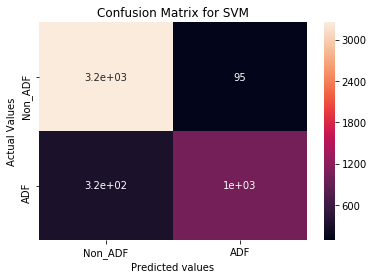

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
ax=plt.subplot()
sns.heatmap(confusion_mat,annot=True,ax=ax);
# labels, title
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual Values');ax.set_title('Confusion Matrix for SVM')
ax.xaxis.set_ticklabels(['Non_ADF','ADF']);ax.yaxis.set_ticklabels(['Non_ADF','ADF']);

                                          Test the generalization of the model (Cross_Validation)

In [69]:
import warnings
from sklearn.cross_validation import cross_val_score
cross_val=cross_val_score(SVM_1,X_train,train_y,cv=3,scoring='f1',n_jobs=-1)
cross_val.mean()

0.794761810534331

                                                  C. Adaptive Boosting

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
estimator=DecisionTreeClassifier(max_depth=3,random_state=100,class_weight='balanced')
AB= AdaBoostClassifier(base_estimator=estimator,random_state=100)

In [71]:
# Choosing the Optimal Parameter using Grid Search
paramgrid={'n_estimators':[200,300,400,500,600],'learning_rate':[0.3,0.5,0.6,0.7,1]}
scorer={'f1_score': make_scorer(f1_score)}
AdaGS=GridSearchCV(AB,param_grid=paramgrid,scoring=scorer,refit='f1_score',cv=3,n_jobs=-1)
AdaBo_Model=AdaGS.fit(X_train,train_y)
AdaBo_Model.best_score_

0.7560652727324192

In [72]:
AdaBo_Model.best_params_

{'learning_rate': 1, 'n_estimators': 300}

                                         Build the model with the optimal parameter

In [73]:
AB_1= AdaBoostClassifier(base_estimator=estimator,n_estimators=300,learning_rate=1,random_state=100)
m1=AB_1.fit(X_train,train_y)

In [74]:
# predict on test set
pred_test_boost=m1.predict(X_test)
metrics.f1_score(test_y,pred_test_boost)

0.7701348081576219

                                                D. Gradient Boosting Model

In [80]:
from sklearn.ensemble import GradientBoostingClassifier
GBM=GradientBoostingClassifier(random_state=100,max_depth=6,max_features='sqrt')

In [81]:
# Choosing the Optimal Parameter using Grid Search
paramgrid={'n_estimators':[500,700,900,1200,1400],'learning_rate':[0.4,0.5,0.6,0.8,1]}
scorer={'f1_score': make_scorer(f1_score)}
GBMCV=GridSearchCV(GBM,param_grid=paramgrid,scoring=scorer,refit='f1_score',cv=3,n_jobs=-1)
GBM_Model=GBMCV.fit(X_train,train_y)
GBM_Model.best_score_

0.7957887910907437

In [77]:
GBM_Model.best_params_

{'learning_rate': 0.4, 'n_estimators': 1400}

                                          Build the model with the optimal parameter

In [82]:
GBM_model=GradientBoostingClassifier(max_depth=6,learning_rate=0.4,n_estimators=1400,random_state=100,max_features='sqrt')
GBM_model=GBM_model.fit(X_train,train_y)

In [83]:
# predict on test set
test_Pred=GBM_model.predict(X_test)
metrics.f1_score(test_y,test_Pred)

0.822095238095238

In [398]:
## Label Encoding ##
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
train_yy= label_encoder.fit_transform(train_y) 

test_yy=label_encoder.fit_transform(test_y)
test_yy

array([4, 3, 1, ..., 3, 2, 4])

                                              06. Implementing Neural Network

In [80]:
from keras.models import Sequential
from keras import layers

Using TensorFlow backend.


In [81]:
X_train.shape

(16000, 10357)

In [82]:
input_dim = X_train.shape[1] # Setting the input dimension i.e length of feature vector - 11244
input_dim

10357

In [83]:
# Create the Model
model = Sequential()
model.add(layers.Dense(100, kernel_initializer = 'uniform',input_dim=input_dim, activation='relu'))
model.add(layers.Dense(80, kernel_initializer = 'uniform',input_dim=input_dim, activation='relu'))
model.add(layers.Dense(50, kernel_initializer = 'uniform',input_dim=input_dim, activation='relu'))

model.add(layers.Dense(22,kernel_initializer = 'uniform',activation='relu'))
model.add(layers.Dense(11, activation='sigmoid'))

In [84]:
# Compile the Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1035800   
_________________________________________________________________
dense_2 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_4 (Dense)              (None, 22)                1122      
_________________________________________________________________
dense_5 (Dense)              (None, 11)                253       
Total params: 1,049,305
Trainable params: 1,049,305
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Fit the Model
history=model.fit(X_train,train_y,epochs=100,verbose=True,validation_data=(X_test,test_y),batch_size=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 16000 samples, validate on 2000 samples
Epoch 1/100
16000/16000 [==============================] - 15s 928us/step - loss: 1.7964 - accuracy: 0.2944 - val_loss: 1.6715 - val_accuracy: 0.3475
Epoch 2/100
16000/16000 [==============================] - 15s 964us/step - loss: 1.3842 - accuracy: 0.3421 - val_loss: 1.0755 - val_accuracy: 0.3695
Epoch 3/100
16000/16000 [==============================] - 16s 1ms/step - loss: 0.8833 - accuracy: 0.4010 - val_loss: 1.0041 - val_accuracy: 0.3775
Epoch 4/100
16000/16000 [==============================] - 14s 873us/step - loss: 0.7316 - accuracy: 0.4281 - val_loss: 1.0610 - val_accuracy: 0.3870
Epoch 5/100
16000/16000 [==============================] - 15s 931us/step - loss: 0.6668 - accuracy: 0.4691 - val_loss: 1.2421 - val_accuracy: 0.4060
Epoch 6/100
16000/16000 [==============================] - 17s 1ms/step - loss: 0.6277 - accuracy: 0.4775 - 

In [92]:
# Evaluate the Model
loss, accuracy = model.evaluate(X_test,test_y,verbose=False)
print("Testing Accuracy:{}".format(accuracy))

Testing Accuracy:0.8869047619047619


In [93]:
y_pred = model.predict(X_test) # Probabilities
y_pred = (y_pred > 0.5)        # Labels

In [94]:
f1_score(test_y,y_pred)

0.8071065989847716

In [95]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

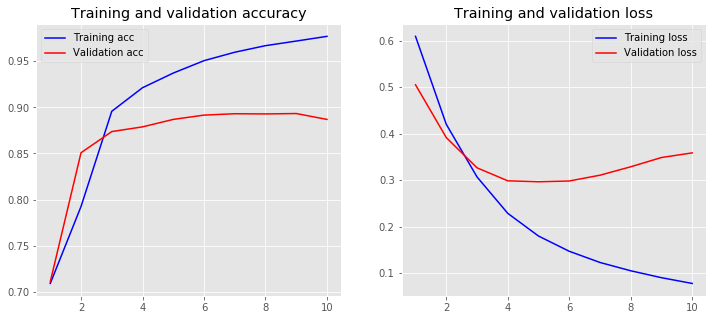

In [96]:
plot_history(history)

                                           07. Word Embedings and Embedding layer                     

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
#data=df.copy()

In [271]:
sentences = data['final_tweet'].values # Raw tweet data
y = data['sentiment'].values

In [272]:
train_x,test_x,train_y,test_y = train_test_split(sentences, y, test_size=0.2, random_state=1000)

In [283]:
# Encode labels in column 'species'. 
train_yy= label_encoder.fit_transform(train_y) 

test_yy=label_encoder.fit_transform(test_y)
test_yy

array([9, 5, 9, ..., 7, 5, 4])

In [273]:
# Word Embeddings represent each word as vectors
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=15000)  # num_words is assumed from previous calculation
tokenizer.fit_on_texts(train_x)

X_train_Embed = tokenizer.texts_to_sequences(train_x) # passing raw train data
X_test_Embed = tokenizer.texts_to_sequences(test_x)   # passing raw text data
 
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train_x[2])
print(X_train_Embed[2]) # To get a feel

['one', 'got', 'phone', 'told', 'tell', 'brat', 'temptation', 'could', 'pass', 'thanks']
[13, 5, 148, 311, 163, 2831, 1962, 36, 664, 34]


In [274]:
vocab_size # Future use

5369

By using word embedding, we end up with varying vector dimension for each sentence. To counter this, we can use pad_sequence() which simply pads the sequence of words with zeros.

                                                       Pad sequence

In [275]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 40
X_train = pad_sequences(X_train_Embed, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test_Embed, padding='post', maxlen=maxlen)

In [276]:
print(X_train[0, :])

[ 230 1077  167   67  196  110  230  338 1266    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


                                         Model -2 Keras Embedding Layer - To learn a new embedding space 

In [277]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dropout

In [294]:
embedding_dim =20
# Create Model
model_2 = Sequential()
model_2.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(10, kernel_initializer = 'uniform',activation='relu'))
model_2.add(layers.Dense(10, kernel_initializer = 'uniform',activation='relu'))
model_2.add(layers.Dense(10, kernel_initializer = 'uniform',activation='relu'))
model_2.add(layers.Dense(10, kernel_initializer = 'uniform',activation='relu'))
model_2.add(layers.Dense(10, kernel_initializer = 'uniform',activation='relu'))
model_2.add(layers.Dense(10, kernel_initializer = 'uniform',activation='relu'))

model_2.add(layers.Dense(11, activation='sigmoid'))

In [295]:
# Compile Model
model_2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 20)            107380    
_________________________________________________________________
flatten_6 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 10)                8010      
_________________________________________________________________
dense_44 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_45 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_46 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_47 (Dense)             (None, 10)              

In [296]:
# Fit the Model
history = model_2.fit(X_train,train_yy,epochs=50,verbose=True,validation_data=(X_test,test_yy), batch_size=50)

Train on 4382 samples, validate on 1096 samples
Epoch 1/50
4382/4382 [==============================] - 4s 827us/step - loss: 2.3734 - accuracy: 0.2257 - val_loss: 2.3077 - val_accuracy: 0.2400
Epoch 2/50
4382/4382 [==============================] - 1s 263us/step - loss: 2.1194 - accuracy: 0.2277 - val_loss: 1.9871 - val_accuracy: 0.2400
Epoch 3/50
4382/4382 [==============================] - 1s 271us/step - loss: 2.0316 - accuracy: 0.2277 - val_loss: 1.9765 - val_accuracy: 0.2400
Epoch 4/50
4382/4382 [==============================] - 2s 366us/step - loss: 2.0131 - accuracy: 0.2277 - val_loss: 1.9582 - val_accuracy: 0.2400
Epoch 5/50
4382/4382 [==============================] - 1s 223us/step - loss: 1.9644 - accuracy: 0.2277 - val_loss: 1.9444 - val_accuracy: 0.2400
Epoch 6/50
4382/4382 [==============================] - 1s 254us/step - loss: 1.8672 - accuracy: 0.2277 - val_loss: 1.9874 - val_accuracy: 0.2400
Epoch 7/50
4382/4382 [==============================] - 1s 185us/step - loss

In [117]:
# Evaluate the Model
loss, accuracy = model_2.evaluate(X_test,test_y, verbose=False)
print("Testing Accuracy: {}".format(accuracy))

Testing Accuracy: 0.9043367346938775


In [118]:
y_pred = model_2.predict(X_test)
y_pred = (y_pred > 0.5)

In [119]:
f1_score(test_y,y_pred)

0.830316742081448

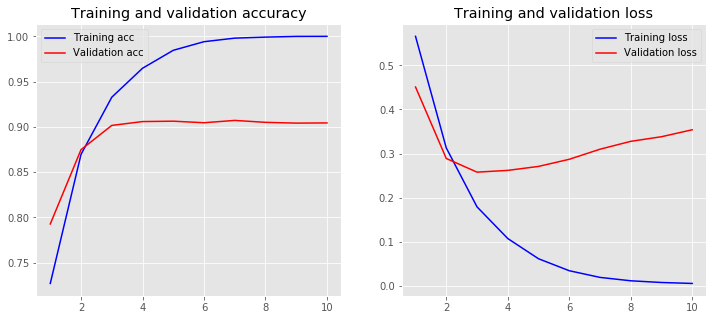

In [120]:
plot_history(history)

                                         07. Model using Convolutional Neural Network

In [121]:
embedding_dim=100
model_3 = Sequential()
model_3.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model_3.add(layers.Conv1D(128, 5, activation='relu'))
model_3.add(layers.MaxPooling1D(5))
model_3.add(layers.Conv1D(64, 4, activation='relu'))
model_3.add(layers.Conv1D(32, 3, activation='relu'))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(10, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [122]:
# Compile the Model
model_3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 100)           1605000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 128)           64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 64)             32832     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 32)             6176      
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
__________

In [123]:
# Fit the Model
history = model_3.fit(X_train,train_y,epochs=2,verbose=True,validation_data=(X_test,test_y), batch_size=25)

Train on 18812 samples, validate on 4704 samples
Epoch 1/2
18812/18812 [==============================] - 60s 3ms/step - loss: 0.3622 - acc: 0.8415 - val_loss: 0.2633 - val_acc: 0.8933
Epoch 2/2
18812/18812 [==============================] - 58s 3ms/step - loss: 0.1419 - acc: 0.9489 - val_loss: 0.2401 - val_acc: 0.9101


In [124]:
# Evaluate the Model
loss, accuracy = model_3.evaluate(X_test,test_y, verbose=False)
print("Testing Accuracy:  {}".format(accuracy))

Testing Accuracy:  0.9100765306122449


In [125]:
y_pred = model_3.predict(X_test)
y_pred = (y_pred > 0.5)

In [126]:
f1_score(test_y,y_pred)

0.8399545970488081

In [127]:
accuracy_score(test_y,y_pred)

0.9100765306122449

In [137]:
con_mat=confusion_matrix(test_y,y_pred)
con_mat

array([[3171,  173],
       [ 250, 1110]], dtype=int64)

In [143]:
report=classification_report(test_y,y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.93      0.95      0.94      3344
          1       0.87      0.82      0.84      1360

avg / total       0.91      0.91      0.91      4704



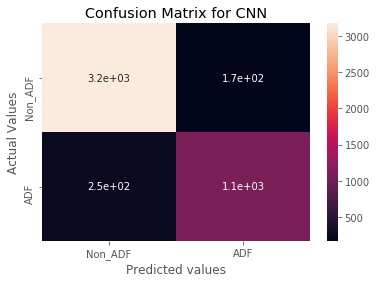

In [145]:
%matplotlib inline
import seaborn as sns
ax=plt.subplot()
sns.heatmap(con_mat,annot=True,ax=ax);
# labels, title
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual Values');ax.set_title('Confusion Matrix for CNN')
ax.xaxis.set_ticklabels(['Non_ADF','ADF']);ax.yaxis.set_ticklabels(['Non_ADF','ADF']);

                                                 Cross Validation for CNN

In [135]:
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)# define 3-fold cross validation test
X=X_train
Y=train_y
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X,Y):
    #create model
    embedding_dim=100
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(64, 4, activation='relu'))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    #Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #Fit the model
    model.fit(X[train],Y[train], epochs=2, batch_size=25, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test],Y[test], verbose=0)
    print("Accuracy {} %".format(scores[1]*100))
    cvscores.append(scores[1] * 100)
print("Mean Accuracy {}".format(numpy.mean(cvscores)))

Accuracy 87.60963163959829 %
Accuracy 89.37968426183392 %
Accuracy 87.36842104312525 %
Mean Accuracy 88.11924564818582


                                                  09. Conclusion

 With this study, we analyed, cleaned the raw twitter data using (Tokenization etc) and extracted the features with the help of Bags of Model (BOW) and Word Embeddings. And we started with base line and traditional ML models. In a aim to achieve better f_score metric, we implemented Neural network and Convolution Neural Network models.
Finally as per our business requirement, classification model for Adverse Drug Reaction and Non-Adverse Reaction from twitter text data with a descent f_score of 84 (CNN Model) is ready to deploy.